In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [5]:
DF = pd.read_csv('data/temperature_data.csv')
DF

,Day,Temperature
0,1,0.133553
1,2,0.061635
2,3,0.175963
3,4,0.302001
4,5,0.082970
...,...,...
360,361,0.091305
361,362,0.235427
362,363,0.031569
363,364,0.109788


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
temperature_data = DF['Temperature'].values

In [7]:
# [1,2,3,4,5,6,7,8] ---->  [1,2,3]-->[4]/ [2,3,4]-->[5]/ [3,4,5]-->[6]

In [15]:
device = 'cuda'

In [16]:
np.random.seed(42)

seq_length = 30
batch_size = 32

class TimeSeriesDataset(Dataset):
  def __init__(self,data,seq_length):
    self.data = data
    self.seq_length = seq_length

  def __len__(self):
    return len(self.data) - self.seq_length

  def __getitem__(self,i):
    x = self.data[i:i+self.seq_length]  # [0:30]  | [1:31]

    y = self.data[i+self.seq_length] # [30] | [31]

    return torch.tensor(x,dtype=torch.float32).unsqueeze(-1),torch.tensor(y,dtype=torch.float32)

dataset = TimeSeriesDataset(temperature_data,seq_length)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=False)

In [22]:
class Generator(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim,seq_length):
    super(Generator,self).__init__()
    self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers=2,batch_first=True)  #(batch_size,seq_length,hidden_dim)
    self.fc = nn.Linear(hidden_dim,output_dim)

  def forward(self,x):
    h_0 = torch.zeros(2,x.size(0),hidden_dim,device=device)
    c_0 = torch.zeros(2,x.size(0),hidden_dim, device=device)

    lstm_out,_ = self.lstm(x,(h_0,c_0))
    out = self.fc(lstm_out)
    return out

class Discriminator(nn.Module):
  def __init__(self,input_dim,hidden_dim):
    super(Discriminator,self).__init__()
    self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers=2,batch_first=True)  #(batch_size,seq_length,hidden_dim)
    self.fc = nn.Linear(hidden_dim,1)

  def forward(self,x):
    h_0 = torch.zeros(2,x.size(0),hidden_dim,device=device)
    c_0 = torch.zeros(2,x.size(0),hidden_dim,device=device)

    lstm_out,_ = self.lstm(x,(h_0,c_0))
    out = self.fc(lstm_out[:,-1,:])
    return out



In [23]:
#Parameters
input_dim = 1
output_dim = 1
hidden_dim = 64
num_epochs = 1500

#Initialize Model
generator = Generator(input_dim,hidden_dim,output_dim,seq_length).to(device)
discriminator = Discriminator(input_dim,hidden_dim).to(device)

#Loss Function & Optimizers
criterion = nn.BCEWithLogitsLoss().to(device)
g_optimizer = optim.Adam(generator.parameters(),lr=0.0001)
d_optimizer = optim.Adam(discriminator.parameters(),lr=0.0001)

In [26]:
#Training Loop

for epoch in range(num_epochs):
  g_loss_epoch = 0
  d_loss_epoch = 0

  for real_batch,_ in dataloader:
    batch_size = real_batch.size(0)
    real_batch = real_batch.to(device)  # [32,30,1]

    real_labels = torch.ones(batch_size,1, device=device)  #(32,1)
    fake_labels = torch.zeros(batch_size,1, device=device)

    #Train the discriminator
    d_optimizer.zero_grad()

    real_output = discriminator(real_batch)
    d_loss_real = criterion(real_output,real_labels)

    noise = torch.randn(batch_size,seq_length,input_dim, device=device)  #(32,30,1)
    fake_data = generator(noise)
    fake_output = discriminator(fake_data)
    d_loss_fake = criterion(fake_output,fake_labels)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    #Train Generator
    g_optimizer.zero_grad()

    noise = torch.randn(batch_size,seq_length,input_dim, device=device)
    fake_data = generator(noise)
    fake_output = discriminator(fake_data)

    g_loss = criterion(fake_output,real_labels)
    g_loss.backward()
    g_optimizer.step()

    g_loss_epoch += g_loss.item()
    d_loss_epoch += d_loss.item()

  if epoch % 100 == 0:
    print (f"Epoch [{epoch+1}/{num_epochs}] Loss D: {d_loss_epoch/len(dataloader):.4f}, Loss G: {g_loss_epoch/len(dataloader):.4f}")



Epoch [1/1500] Loss D: 1.3868, Loss G: 0.6918
Epoch [101/1500] Loss D: 0.9125, Loss G: 1.1933
Epoch [201/1500] Loss D: 1.5947, Loss G: 0.8151
Epoch [301/1500] Loss D: 1.3567, Loss G: 0.8329
Epoch [401/1500] Loss D: 1.3894, Loss G: 0.8301
Epoch [501/1500] Loss D: 1.3830, Loss G: 0.7021
Epoch [601/1500] Loss D: 1.4101, Loss G: 0.6224
Epoch [701/1500] Loss D: 1.3911, Loss G: 0.6995
Epoch [801/1500] Loss D: 1.3849, Loss G: 0.6937
Epoch [901/1500] Loss D: 1.3850, Loss G: 0.6918
Epoch [1001/1500] Loss D: 1.3855, Loss G: 0.6877
Epoch [1101/1500] Loss D: 1.3815, Loss G: 0.6939
Epoch [1201/1500] Loss D: 1.3486, Loss G: 0.7128
Epoch [1301/1500] Loss D: 1.3806, Loss G: 0.6864
Epoch [1401/1500] Loss D: 1.3867, Loss G: 0.6931


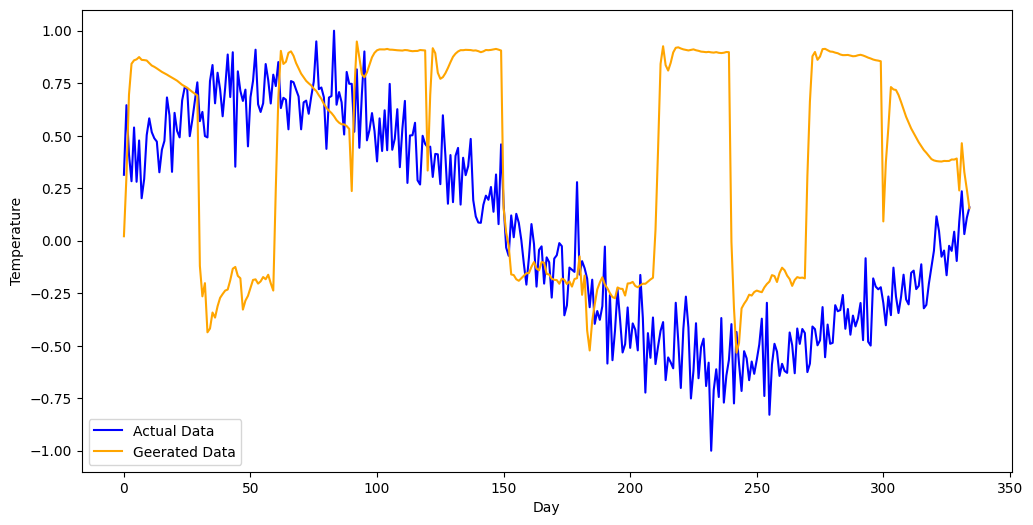

In [27]:
num_sequences = len(temperature_data) - seq_length

noise = torch.randn(num_sequences,seq_length,input_dim, device=device)

generated_data = generator(noise).detach().cpu().numpy().flatten()[:num_sequences]

actual_data = temperature_data[seq_length:seq_length+num_sequences]  #[30:365]

# Plot the actual and generated data

plt.figure(figsize=(12,6))
plt.plot(actual_data,label='Actual Data',color='blue')
plt.plot(range(len(actual_data)),generated_data,label='Geerated Data',color='orange')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [28]:
mse =mean_squared_error(actual_data,generated_data)
mae =mean_absolute_error(actual_data,generated_data)
correlation = np.corrcoef(actual_data,generated_data)[0,1]

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Correlation Coeff: {correlation:.4f}")

Mean Squared Error: 0.5237
Mean Absolute Error: 0.5651
Correlation Coeff: 0.1733
